In [1]:
# Standard library imports
import csv
import os
import pickle
from collections import Counter
from itertools import combinations
import math
from math import sqrt

# Third-party library imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from tqdm.notebook import tqdm

# Scikit-learn imports
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    auc
)
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif

# Local imports
from utils import *

# Create 'images' directory if it doesn't exist

In [2]:
speech = pd.read_csv('outliercorrected_pd_speech_features.csv',header=[0,1],index_col=0)
display(speech)

# make a list of columns that contain all features, that are not patient id, class and gender
column_list = list(speech.columns)
feature_columns  = column_list.copy()
feature_columns.remove(('Info','class'))
feature_columns.remove(('Info','gender'))
display(feature_columns)

Info Baseline Features                                                   \
    gender               PPE       DFA      RPDE   numPulses numPeriodsPulses   
ID                                                                              
0      1.0          0.823387  0.696370  0.567250  235.333333       234.333333   
1      0.0          0.422263  0.793993  0.592453  213.333333       211.000000   
2      1.0          0.801973  0.619967  0.520563  319.333333       318.333333   
3      0.0          0.828707  0.626097  0.537183  493.000000       492.000000   
4      0.0          0.831287  0.779397  0.726717  362.666667       361.666667   
..     ...               ...       ...       ...         ...              ...   
247    0.0          0.751703  0.651830  0.586847  326.000000       324.666667   
248    1.0          0.611750  0.688327  0.452343  356.666667       355.333333   
249    1.0          0.819857  0.788800  0.373520  339.666667       338.666667   
250    0.0          0.600530  0.569010  0.411987  402.333333       401.000000   
251    0.0          0.844917  0.745653  0.476707  353.666667       352.666667   

                                                                   ...  \
    meanPeriodPulses stdDevPeriodPulses locPctJitter locAbsJitter  ...   
ID                                                                 ...   
0           0.008220           0.000073     0.001963     0.000016  ...   
1           0.008884           0.001849     0.005790     0.000050  ...   
2           0.006041           0.000104     0.002217     0.000013  ...   
3           0.003913           0.000042     0.000757     0.000003  ...   
4           0.005622           0.002023     0.003593     0.000021  ...   
..               ...                ...          ...          ...  ...   
247         0.005911           0.000251     0.003193     0.000019  ...   
248         0.005410           0.000964     0.002467     0.000014  ...   
249         0.005684           0.000042     0.000800     0.000005  ...   
250         0.004775           0.000103     0.000983     0.000005  ...   
251         0.005475           0.000065     0.000820     0.000005  ...   

                TQWT Features                            \
    tqwt_kurtosisValue_dec_28 tqwt_kurtosisValue_dec_29   
ID                                                        
0                    1.561733                  2.862000   
1                    4.918567                  4.827133   
2                   41.129400                 31.201933   
3                    1.677633                  1.908400   
4                    4.104600                  4.285233   
..                        ...                       ...   
247                 19.298667                 15.072200   
248                  4.448533                  3.180933   
249                 90.482767                 65.641367   
250                  2.674667                  2.714200   
251                 44.571367                 26.370167   

                                                         \
    tqwt_kurtosisValue_dec_30 tqwt_kurtosisValue_dec_31   
ID                                                        
0                   12.293333                  9.717500   
1                    6.117633                  8.599667   
2                   14.584467                  5.446800   
3                    2.842167                  3.493867   
4                    2.953200                  2.799933   
..                        ...                       ...   
247                 13.479700                 14.877933   
248                  2.880233                  2.805067   
249                 29.098533                  8.966500   
250                  2.706000                  2.637700   
251                 14.782567                  4.455833   

                                                         \
    tqwt_kurtosisValue_dec_32 tqwt_kurtosisValue_dec_33   
ID                                                        
0  

[('Baseline Features', 'PPE'),
 ('Baseline Features', 'DFA'),
 ('Baseline Features', 'RPDE'),
 ('Baseline Features', 'numPulses'),
 ('Baseline Features', 'numPeriodsPulses'),
 ('Baseline Features', 'meanPeriodPulses'),
 ('Baseline Features', 'stdDevPeriodPulses'),
 ('Baseline Features', 'locPctJitter'),
 ('Baseline Features', 'locAbsJitter'),
 ('Baseline Features', 'rapJitter'),
 ('Baseline Features', 'ppq5Jitter'),
 ('Baseline Features', 'ddpJitter'),
 ('Baseline Features', 'locShimmer'),
 ('Baseline Features', 'locDbShimmer'),
 ('Baseline Features', 'apq3Shimmer'),
 ('Baseline Features', 'apq5Shimmer'),
 ('Baseline Features', 'apq11Shimmer'),
 ('Baseline Features', 'ddaShimmer'),
 ('Baseline Features', 'meanAutoCorrHarmonicity'),
 ('Baseline Features', 'meanNoiseToHarmHarmonicity'),
 ('Baseline Features', 'meanHarmToNoiseHarmonicity'),
 ('Intensity Parameters', 'minIntensity'),
 ('Intensity Parameters', 'maxIntensity'),
 ('Intensity Parameters', 'meanIntensity'),
 ('Formant Frequenci

make train test split

In [3]:
gender = speech[('Info','gender')]
y = speech[('Info','class')]

X_train_val, X_test, y_train_val, y_test, gender_train, gender_test = train_test_split(
    speech[feature_columns], y, gender, test_size=0.2, random_state=42)

In [4]:
# Define the filename for the top features
TOP_FEATURES_FILE = 'top_features.pkl'

# Check if the file exists
if os.path.exists(TOP_FEATURES_FILE):
    print(f"Loading top features from {TOP_FEATURES_FILE}")
    with open(TOP_FEATURES_FILE, 'rb') as f:
        top_features = pickle.load(f)
else:
    print(f"File {TOP_FEATURES_FILE} not found. Running feature selection process...")
    
    seed_list = range(1,101)
    results_df = pd.DataFrame()
    
    for random_state in tqdm(seed_list):
        print(random_state)
        X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=random_state)
        speech_temp = X_train_val.copy()
        result_df = feature_selection_and_evaluation(X_train, X_val, y_train, y_val, int(sqrt(len(feature_columns))), 1000)
        result_df['random state'] = random_state
        results_df = pd.concat([results_df, result_df], axis=0)

    feature_counts = Counter()
    for feature in results_df['Selected Features'].values:
        feature_counts.update(feature)
    
    top_features = [feature for feature, count in feature_counts.most_common(int(sqrt(len(feature_columns))))]
    
    # Save top_features using pickle
    with open(TOP_FEATURES_FILE, 'wb') as f:
        pickle.dump(top_features, f)
    
    print(f"Top features saved to {TOP_FEATURES_FILE}")

# Display top features
print("Top features:")
display(top_features)

Loading top features from top_features.pkl
Top features:


[('MFCC ', 'std_8th_delta_delta'),
 ('TQWT Features', 'tqwt_kurtosisValue_dec_27'),
 ('MFCC ', 'mean_MFCC_2nd_coef'),
 ('TQWT Features', 'tqwt_kurtosisValue_dec_26'),
 ('MFCC ', 'std_8th_delta'),
 ('MFCC ', 'std_9th_delta_delta'),
 ('MFCC ', 'std_7th_delta_delta'),
 ('MFCC ', 'std_6th_delta_delta'),
 ('MFCC ', 'std_9th_delta'),
 ('MFCC ', 'std_7th_delta'),
 ('MFCC ', 'std_6th_delta'),
 ('TQWT Features', 'tqwt_minValue_dec_12'),
 ('MFCC ', 'std_11th_delta_delta'),
 ('TQWT Features', 'tqwt_stdValue_dec_12'),
 ('MFCC ', 'std_delta_delta_log_energy'),
 ('TQWT Features', 'tqwt_maxValue_dec_12'),
 ('MFCC ', 'std_11th_delta'),
 ('MFCC ', 'std_10th_delta_delta'),
 ('TQWT Features', 'tqwt_maxValue_dec_11'),
 ('TQWT Features', 'tqwt_stdValue_dec_11'),
 ('TQWT Features', 'tqwt_minValue_dec_13'),
 ('TQWT Features', 'tqwt_entropy_log_dec_12'),
 ('TQWT Features', 'tqwt_kurtosisValue_dec_28'),
 ('MFCC ', 'std_10th_delta'),
 ('TQWT Features', 'tqwt_entropy_shannon_dec_15'),
 ('MFCC ', 'std_12th_delta_

Overall accuracy: 0.843


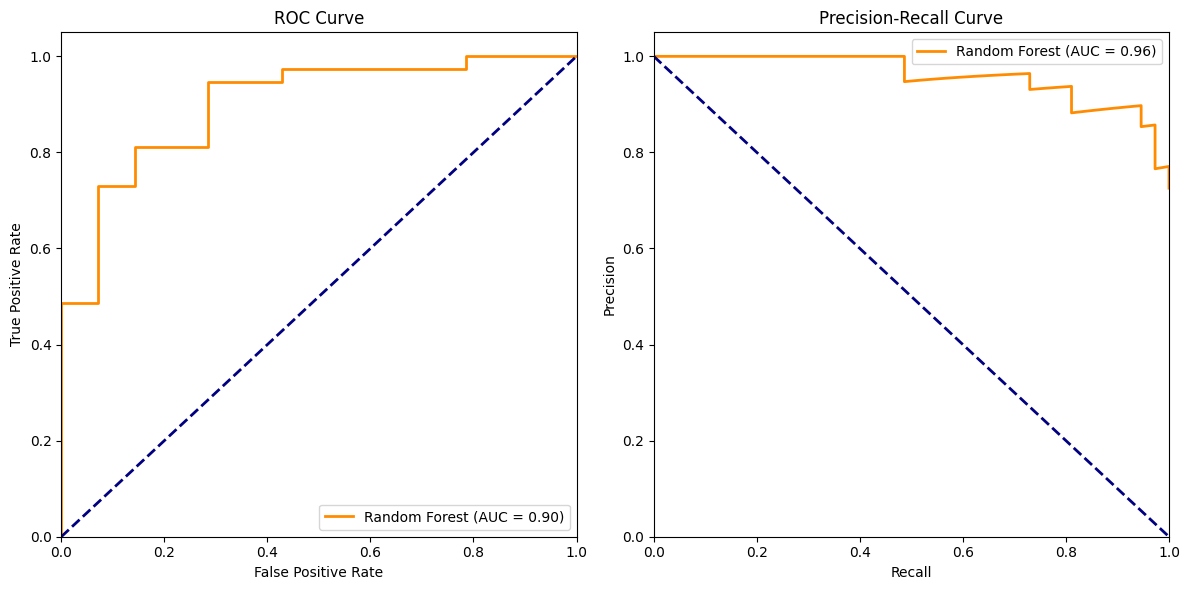

In [5]:
rf = RandomForestClassifier(n_estimators=1000, random_state=42, n_jobs=-1)
# Get probability predictions
rf.fit(X_train_val[top_features],y_train_val)

# Overall performance
y_pred = rf.predict(X_test[top_features])
print(f"Overall accuracy: {accuracy_score(y_test, y_pred):.3f}")
y_pred_proba = rf.predict_proba(X_test[top_features])

# Calculate ROC AUC score
auc_roc = roc_auc_score(y_test, y_pred_proba[:, 1])

# Generate ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:, 1])

# Calculate Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba[:, 1])
auc_pr = auc(recall, precision)

# Plot ROC curve
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Random Forest (AUC = {auc_roc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")

# Plot Precision-Recall curve
plt.subplot(122)
plt.plot(recall, precision, color='darkorange', lw=2, label=f'Random Forest (AUC = {auc_pr:.2f})')
plt.plot([0, 1], [1, 0], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="upper right")

plt.tight_layout()
plt.show()

Loading Anova DF from Anova_feature_sets.pkl

Top results:


,Feature_Sets,Amount_of_Features,AUC_ROC,AUC_PR
0,Baseline Features - Formant Frequencies - Voca...,563,0.955598,0.983384
1,Baseline Features - Bandwidth Parameters - Voc...,563,0.953668,0.982468
2,Baseline Features - MFCC - TQWT Features,537,0.953668,0.982078
3,MFCC - TQWT Features,516,0.949807,0.981630
4,Intensity Parameters - MFCC - TQWT Features,519,0.948842,0.981375


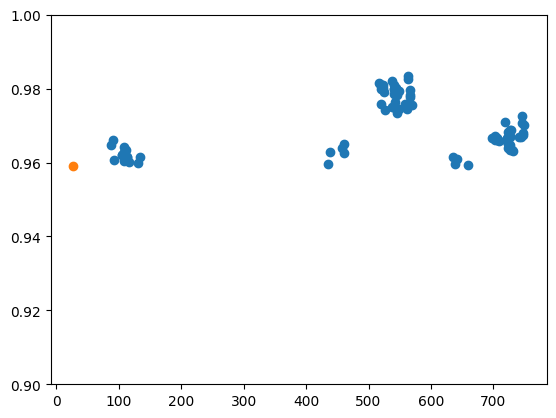

In [6]:
# Define the filename for the top features
ANOVA_FILE = 'Anova_feature_sets.pkl'
# Check if the file exists
if os.path.exists(ANOVA_FILE):
    print(f"Loading Anova DF from {ANOVA_FILE}")
    with open(ANOVA_FILE, 'rb') as f:
        results_df = pickle.load(f)

else:
    list_featuresets = list(pd.unique(speech.columns.get_level_values(0)))
    list_featuresets.remove('Info')
    combination_list = []
    for i in range(len(list_featuresets)):
        combination_list_temp = list(combinations(list_featuresets,i))
        combination_list.extend(combination_list_temp)

    # Create an empty DataFrame to store results
    results_df = pd.DataFrame(columns=['Feature_Sets', 'Amount_of_Features', 'AUC_ROC', 'AUC_PR'])

    for feature_sets in tqdm(combination_list, leave=False):
        if not feature_sets:
            continue
        rf_baseline = RandomForestClassifier(n_estimators=1000, random_state=42, n_jobs=-1)
        selected_columns = X_train_val.columns[X_train_val.columns.get_level_values(0).isin(feature_sets)]
        rf_baseline.fit(X_train_val[selected_columns], y_train_val)
        y_pred_proba = rf_baseline.predict_proba(X_test[selected_columns])

        # Calculate ROC AUC score
        auc_roc = roc_auc_score(y_test, y_pred_proba[:, 1])

        # Generate ROC curve
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:, 1])

        # Calculate Precision-Recall curve
        precision, recall, _ = precision_recall_curve(y_test, y_pred_proba[:, 1])
        auc_pr_test = auc(recall, precision)

        if auc_pr_test > auc_pr:
            # Add results to the DataFrame
            new_row = pd.DataFrame({
                'Feature_Sets': [' - '.join(feature_sets)],
                'Amount_of_Features': [len(selected_columns)],
                'AUC_ROC': [auc_roc],
                'AUC_PR': [auc_pr_test]
            })
            if len(results_df.index) == 0:
                results_df = new_row
            results_df = pd.concat([results_df, new_row], ignore_index=True)

    # Sort the results DataFrame by AUC_PR in descending order
    results_df = results_df.sort_values('AUC_PR', ascending=False).reset_index(drop=True)

    # Save top_features using pickle
    with open(ANOVA_FILE, 'wb') as f:
        pickle.dump(results_df, f)

# Display the results
print("\nTop results:")
display(results_df.head())

plt.scatter(results_df['Amount_of_Features'],results_df['AUC_PR'])
plt.scatter(int(sqrt(len(feature_columns))), auc_pr)
plt.ylim([0.9,1])
plt.show()


sensitivity analysis

Female accuracy: 0.862
Male accuracy: 0.818


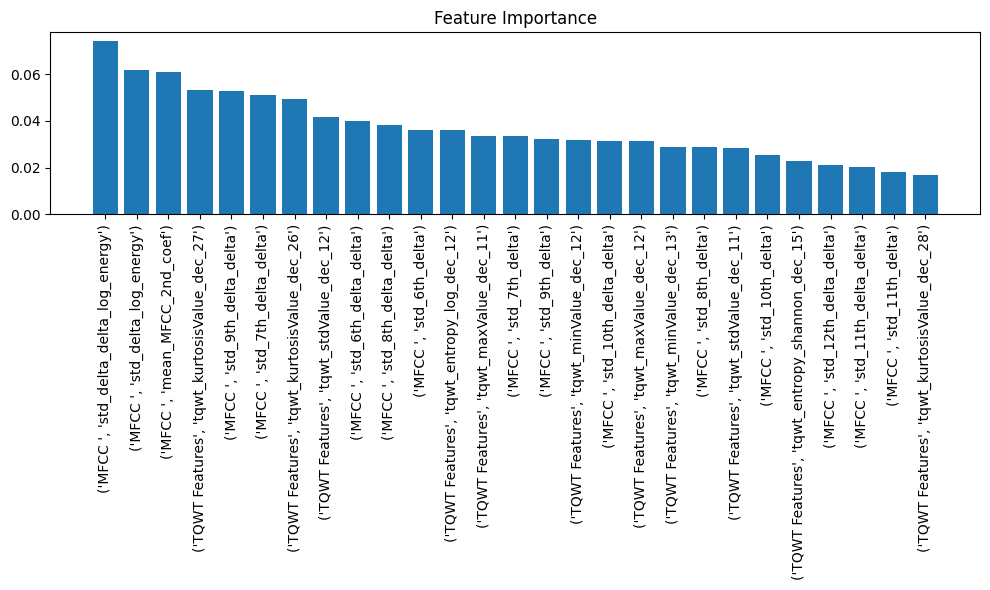

C:\Users\bradn\AppData\Local\Temp\ipykernel_30072\355600721.py:39: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  gender_df = pd.concat([gender_df, new_row], ignore_index=True)


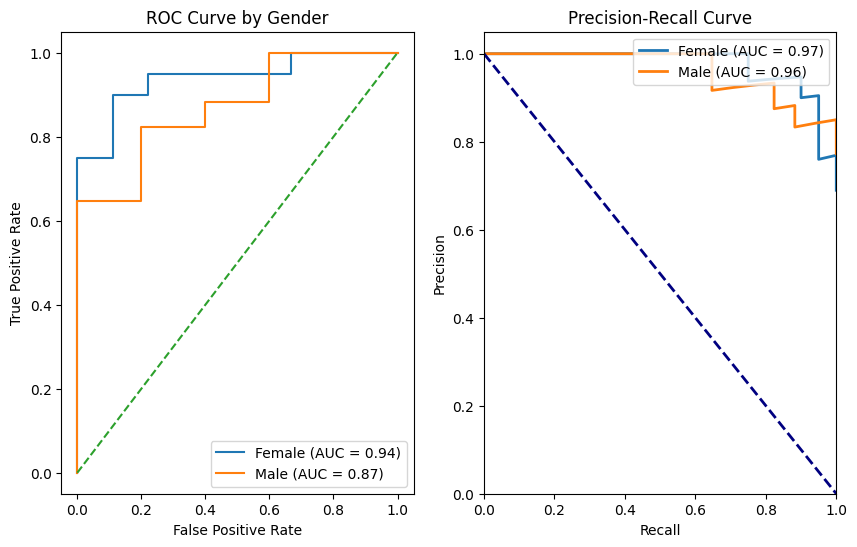

,feature removed,auc_roc,gender
0,"(MFCC , std_8th_delta_delta)",0.843137,all
1,"(TQWT Features, tqwt_kurtosisValue_dec_27)",0.843137,all
2,"(MFCC , mean_MFCC_2nd_coef)",0.823529,all
3,"(TQWT Features, tqwt_kurtosisValue_dec_26)",0.843137,all
4,"(MFCC , std_8th_delta)",0.862745,all
...,...,...,...
76,"(TQWT Features, tqwt_kurtosisValue_dec_28)",0.818182,Male
77,"(MFCC , std_10th_delta)",0.818182,Male
78,"(TQWT Features, tqwt_entropy_shannon_dec_15)",0.818182,Male
79,"(MFCC , std_12th_delta_delta)",0.818182,Male


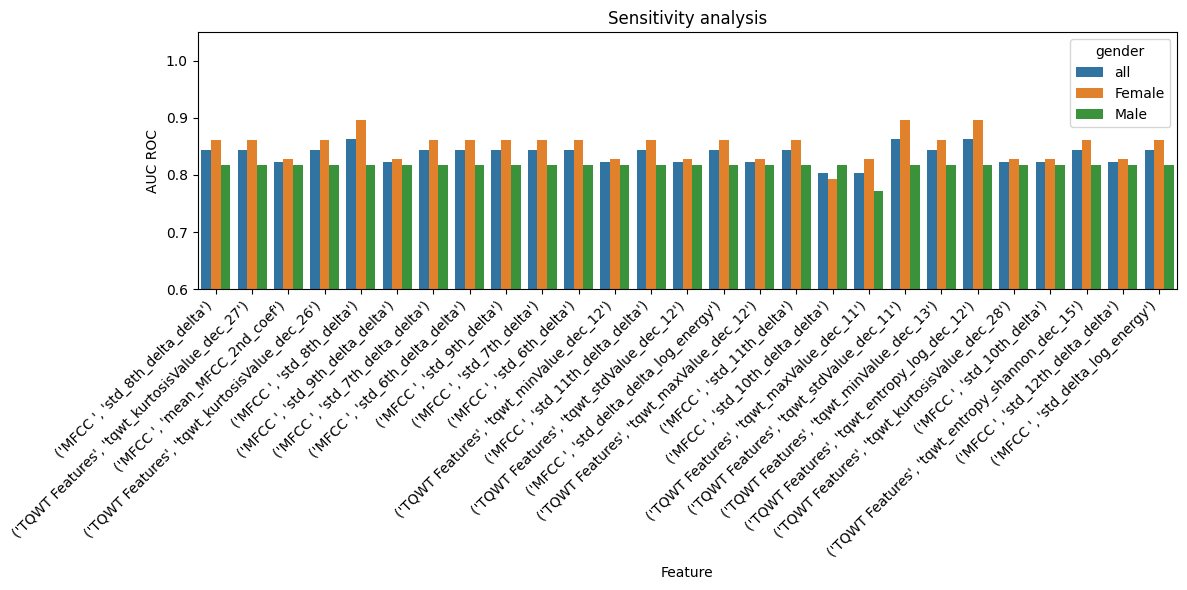

In [7]:
X_test = X_test[top_features].copy()
# Gender-specific performance
for gender_label in [0, 1]:
    if gender_label == 0:
        gender = 'Female'
    else:
        gender = 'Male'
    gender_mask = (gender_test == gender_label)
    y_gender = y_test[gender_mask]
    X_gender = X_test[gender_mask]
    y_pred_gender = rf.predict(X_gender)
    print(f"{gender} accuracy: {accuracy_score(y_gender, y_pred_gender):.3f}")

# Feature importance
importances = rf.feature_importances_
feature_importance = pd.DataFrame({'feature': top_features, 'importance': importances})
feature_importance = feature_importance.sort_values('importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.bar(feature_importance['feature'].astype(str), feature_importance['importance'])
plt.xticks(rotation=90)
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

gender_df = pd.DataFrame(columns=['feature removed', 'auc_roc','gender'])

# Sensitivity analysis
for feature in top_features:
    X_test_mod = X_test.copy()
    X_test_mod.iloc[:, top_features.index(feature)] = 0  # Set feature to 0
    y_pred_mod = rf.predict(X_test_mod)
    auc_roc = accuracy_score(y_test, y_pred_mod)
    new_row = pd.DataFrame([{'feature removed': feature, 
                        'auc_roc': auc_roc,
                        'gender': 'all'}])

    gender_df = pd.concat([gender_df, new_row], ignore_index=True)

    

# ROC curves for each gender
plt.figure(figsize=(10, 6))
for gender_label in [0, 1]:
    
    gender_mask = (gender_test == gender_label)
    if gender_label == 0:
        gender = 'Female'
    else:
        gender = 'Male'
    y_gender = y_test[gender_mask]
    X_gender = X_test[gender_mask]
    y_pred_proba = rf.predict_proba(X_gender)[:, 1]
    fpr, tpr, _ = roc_curve(y_gender, y_pred_proba)
    auc_roc = roc_auc_score(y_gender, y_pred_proba)
    plt.subplot(121)
    plt.plot(fpr, tpr, label=f'{gender} (AUC = {auc_roc:.2f})')

    # Calculate Precision-Recall curve
    precision, recall, _ = precision_recall_curve(y_gender, y_pred_proba)
    auc_prc = auc(recall, precision)

    # Plot Precision-Recall curve
    plt.subplot(122)
    plt.plot(recall, precision, lw=2, label=f'{gender} (AUC = {auc_prc:.2f})')
    # Sensitivity analysis
    for feature in top_features:
        X_test_mod = X_gender.copy()
        X_test_mod.iloc[:, top_features.index(feature)] = 0  # Set feature to 0
        y_pred_mod = rf.predict(X_test_mod)
        auc_roc = accuracy_score(y_gender, y_pred_mod)
        new_row = pd.DataFrame([{'feature removed': feature, 
                                'auc_roc': auc_roc,
                                'gender': gender}])

        gender_df = pd.concat([gender_df, new_row], ignore_index=True)

plt.subplot(121)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve by Gender')
plt.legend()

plt.subplot(122)
plt.plot([0, 1], [1, 0], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="upper right")

plt.show()

display(gender_df)

# Convert 'feature removed' to string if it contains lists or tuples
gender_df['feature removed'] = gender_df['feature removed'].apply(lambda x: str(x) if isinstance(x, (list, tuple)) else x)

plt.figure(figsize=(12, 6))  # Adjust the figure size as needed
sns.barplot(x='feature removed', y='auc_roc', hue='gender', data=gender_df)

# Customize the plot
plt.title('Sensitivity analysis')
plt.xlabel('Feature')
plt.ylabel('AUC ROC')
plt.ylim([0.6, 1.05])

# Rotate x-axis labels if they are long
plt.xticks(rotation=45, ha='right')

# Adjust layout to prevent cutting off labels
plt.tight_layout()

# Show the plot
plt.show()

,Feature,Gender,F-value,p-value
39,"('TQWT Features', 'tqwt_stdValue_dec_11')",Female,19.258056,0.000157
37,"('TQWT Features', 'tqwt_maxValue_dec_11')",Female,18.662572,0.000189
23,"('TQWT Features', 'tqwt_minValue_dec_12')",Female,16.388545,0.000389
31,"('TQWT Features', 'tqwt_maxValue_dec_12')",Female,15.883291,0.000460
26,"('TQWT Features', 'tqwt_stdValue_dec_12')",Male,17.486288,0.000460
41,"('TQWT Features', 'tqwt_minValue_dec_13')",Female,14.029976,0.000864
27,"('TQWT Features', 'tqwt_stdValue_dec_12')",Female,13.877440,0.000911
53,"('MFCC ', 'std_delta_log_energy')",Female,13.397555,0.001079
29,"('MFCC ', 'std_delta_delta_log_energy')",Female,12.782969,0.001345
30,"('TQWT Features', 'tqwt_maxValue_dec_12')",Male,13.715222,0.001406


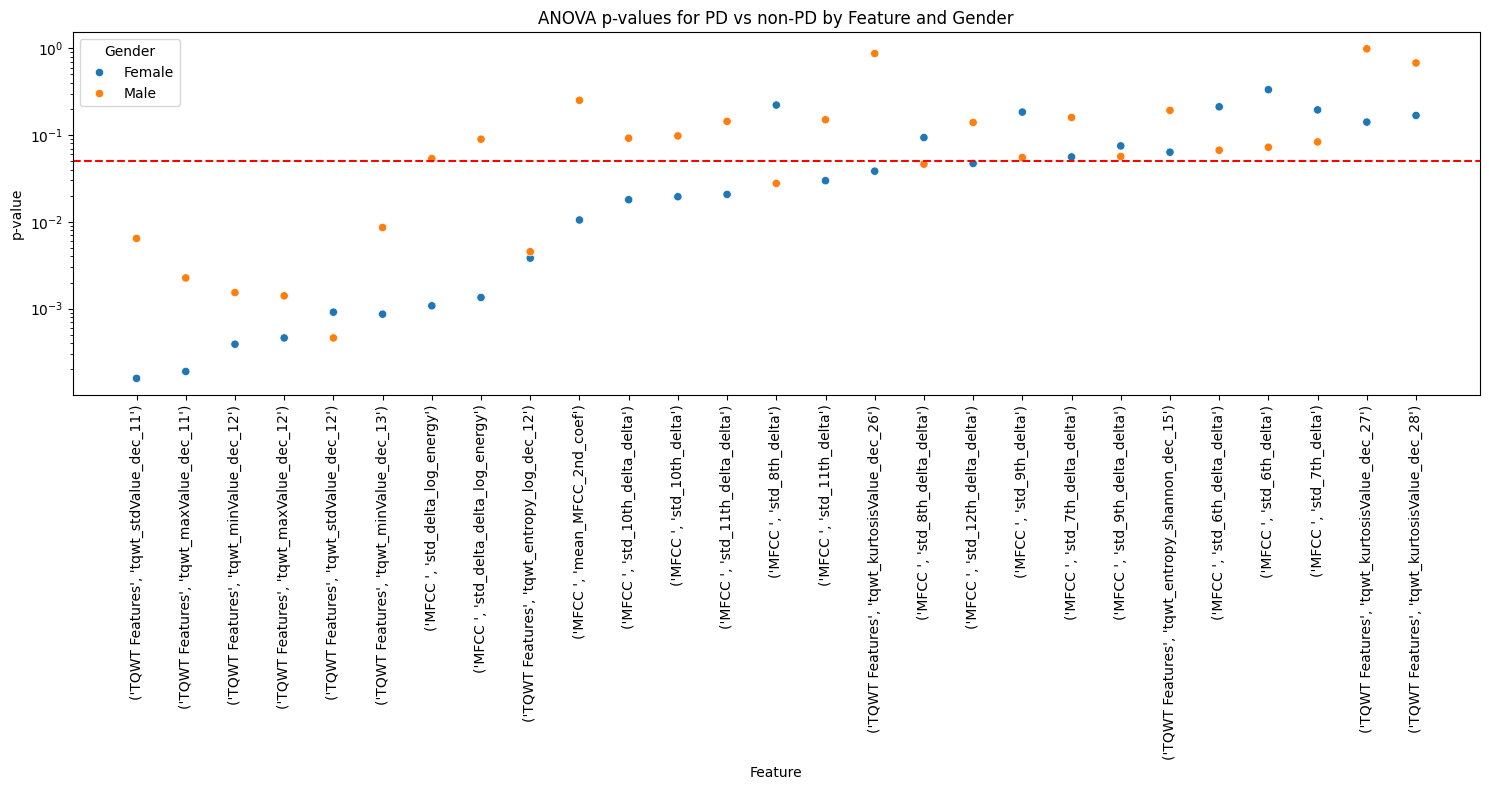

In [8]:
combined_df = pd.concat([X_test, y_test, gender_test], axis=1)
# Perform ANOVA
anova_results = perform_anova(combined_df, top_features, pd_column=('Info','class'), gender_column=('Info','gender'))
anova_results['Feature'] = anova_results['Feature'].astype(str)
# Sort results by p-value
anova_results = anova_results.sort_values('p-value')

# Print results
display(anova_results)

# Visualize results
plt.figure(figsize=(15, 8))
sns.scatterplot(x='Feature', y='p-value', hue='Gender', data=anova_results)
plt.yscale('log')
plt.axhline(y=0.05, color='r', linestyle='--')
plt.xticks(rotation=90)
plt.title('ANOVA p-values for PD vs non-PD by Feature and Gender')
plt.tight_layout()
plt.show()

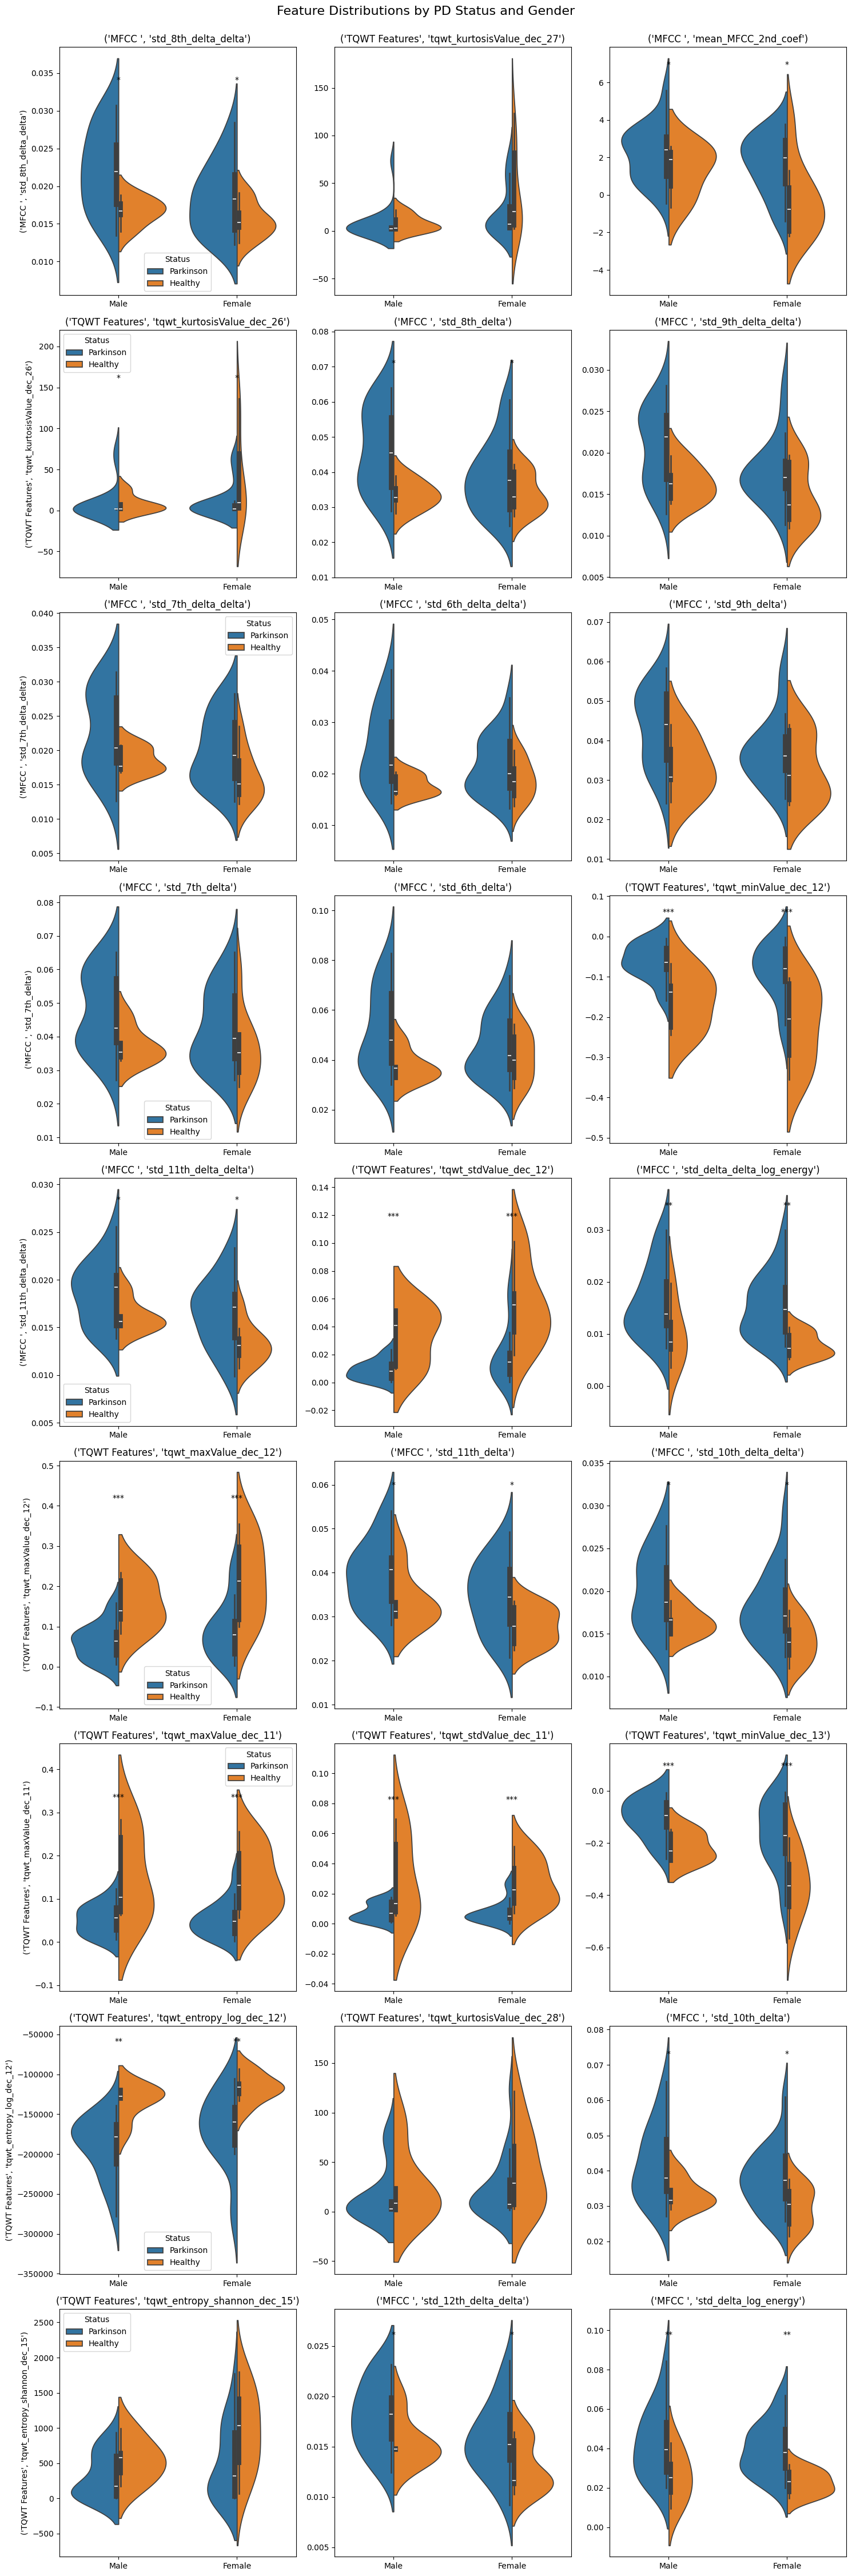

In [9]:
# Create the plot
plot_feature_distributions(combined_df, top_features, pd_column=('Info','class'), gender_column=('Info','gender'), anova_results=anova_results)

In [10]:
test = anova_results[anova_results['p-value']<0.06]

# Assuming 'test' is your original DataFrame
new_df_list = []

for feature in test['Feature'].unique():
    feature_data = test[test['Feature'] == feature]
    
    if len(feature_data) == 2:
        male_data = feature_data[feature_data['Gender'] == 'Male']
        female_data = feature_data[feature_data['Gender'] == 'Female']
        
        new_row = {
            'Feature': feature,
            'F-value_Male': male_data['F-value'].values[0],
            'F-value_Female': female_data['F-value'].values[0],
            'p-value_Male': male_data['p-value'].values[0],
            'p-value_Female': female_data['p-value'].values[0]
        }
        
        new_df_list.append(new_row)

# Create the new DataFrame from the list of dictionaries
new_df = pd.DataFrame(new_df_list)

# Set 'Feature' as the index
new_df.set_index('Feature', inplace=True)

# Display the new DataFrame
display(new_df)
list(new_df.index)

,F-value_Male,F-value_Female,p-value_Male,p-value_Female
Feature,,,,
"('TQWT Features', 'tqwt_stdValue_dec_11')",9.251314,19.258056,0.006442,0.000157
"('TQWT Features', 'tqwt_maxValue_dec_11')",12.245273,18.662572,0.002259,0.000189
"('TQWT Features', 'tqwt_minValue_dec_12')",13.443743,16.388545,0.001532,0.000389
"('TQWT Features', 'tqwt_maxValue_dec_12')",13.715222,15.883291,0.001406,0.000460
"('TQWT Features', 'tqwt_stdValue_dec_12')",17.486288,13.877440,0.000460,0.000911
"('TQWT Features', 'tqwt_minValue_dec_13')",8.480947,14.029976,0.008616,0.000864
"('MFCC ', 'std_delta_log_energy')",4.207099,13.397555,0.053586,0.001079
"('TQWT Features', 'tqwt_entropy_log_dec_12')",10.216620,10.016794,0.004534,0.003820


["('TQWT Features', 'tqwt_stdValue_dec_11')",
 "('TQWT Features', 'tqwt_maxValue_dec_11')",
 "('TQWT Features', 'tqwt_minValue_dec_12')",
 "('TQWT Features', 'tqwt_maxValue_dec_12')",
 "('TQWT Features', 'tqwt_stdValue_dec_12')",
 "('TQWT Features', 'tqwt_minValue_dec_13')",
 "('MFCC ', 'std_delta_log_energy')",
 "('TQWT Features', 'tqwt_entropy_log_dec_12')"]

Overall accuracy: 0.843


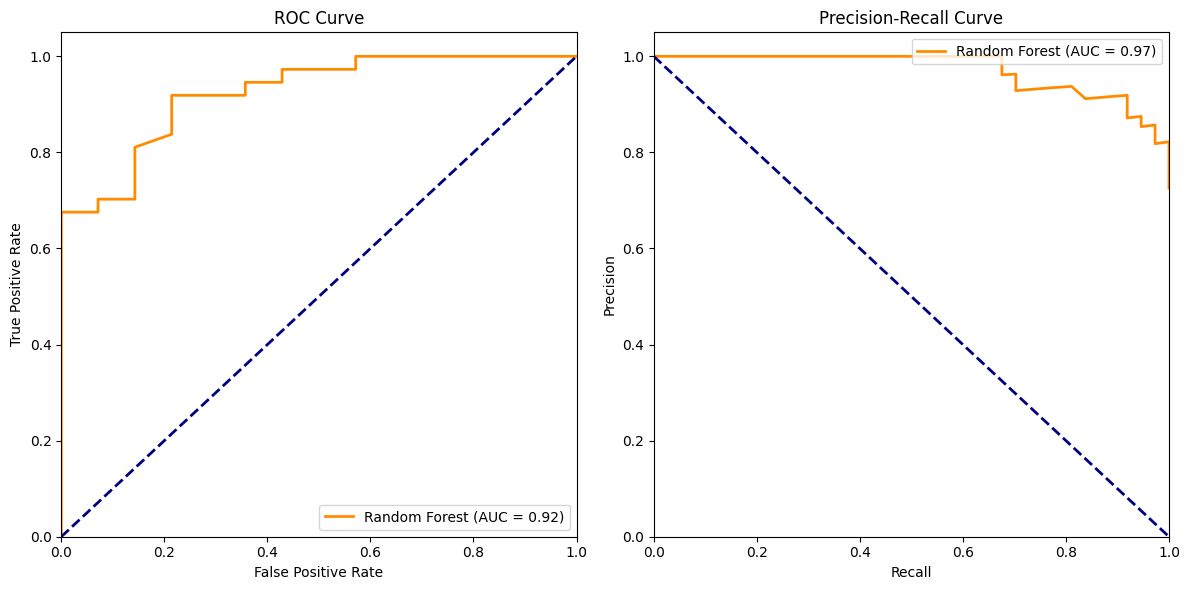

In [11]:
feature_list = [('TQWT Features', 'tqwt_stdValue_dec_11'),
 ('TQWT Features', 'tqwt_maxValue_dec_11'),
 ('TQWT Features', 'tqwt_minValue_dec_12'),
 ('TQWT Features', 'tqwt_maxValue_dec_12'),
 ('TQWT Features', 'tqwt_stdValue_dec_12'),
 ('TQWT Features', 'tqwt_minValue_dec_13'),
 ('MFCC ', 'std_delta_log_energy'),
 ('TQWT Features', 'tqwt_entropy_log_dec_12')]
rf_small = RandomForestClassifier(n_estimators=1000, random_state=42, n_jobs=-1)
# Get probability predictions
rf_small.fit(X_train_val[feature_list],y_train_val)

# Overall performance
y_pred = rf_small.predict(X_test[feature_list])
print(f"Overall accuracy: {accuracy_score(y_test, y_pred):.3f}")
y_pred_proba = rf_small.predict_proba(X_test[feature_list])

# Calculate ROC AUC score
auc_roc = roc_auc_score(y_test, y_pred_proba[:, 1])

# Generate ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:, 1])

# Calculate Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba[:, 1])
auc_pr = auc(recall, precision)

# Plot ROC curve
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Random Forest (AUC = {auc_roc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")

# Plot Precision-Recall curve
plt.subplot(122)
plt.plot(recall, precision, color='darkorange', lw=2, label=f'Random Forest (AUC = {auc_pr:.2f})')
plt.plot([0, 1], [1, 0], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="upper right")

plt.tight_layout()
plt.show()

Female accuracy: 0.862
Male accuracy: 0.818


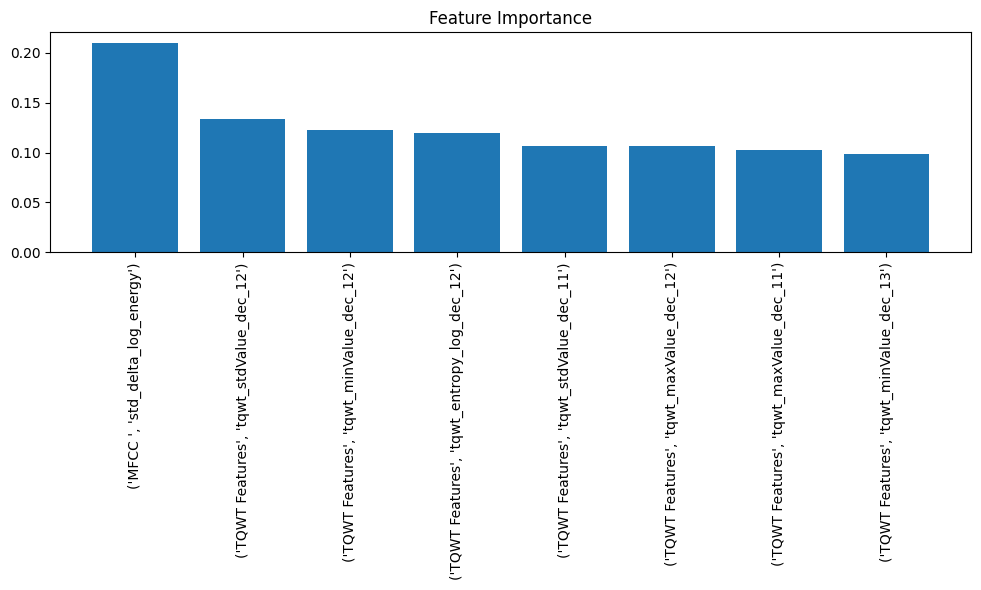

C:\Users\bradn\AppData\Local\Temp\ipykernel_30072\3042926345.py:36: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  gender_df = pd.concat([gender_df, pd.DataFrame([new_row])], ignore_index=True)


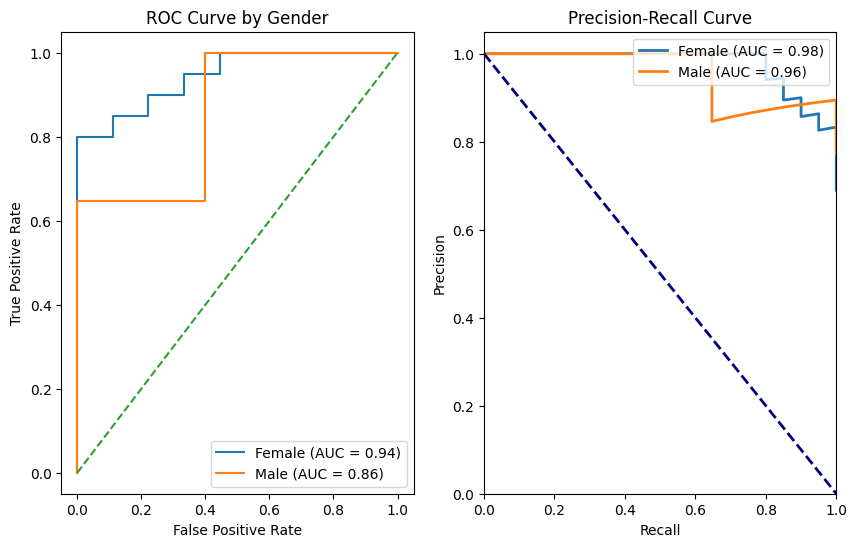

,feature removed,auc_roc,gender
0,"(TQWT Features, tqwt_stdValue_dec_11)",0.843137,all
1,"(TQWT Features, tqwt_maxValue_dec_11)",0.862745,all
2,"(TQWT Features, tqwt_minValue_dec_12)",0.843137,all
3,"(TQWT Features, tqwt_maxValue_dec_12)",0.843137,all
4,"(TQWT Features, tqwt_stdValue_dec_12)",0.862745,all
5,"(TQWT Features, tqwt_minValue_dec_13)",0.862745,all
6,"(MFCC , std_delta_log_energy)",0.686275,all
7,"(TQWT Features, tqwt_entropy_log_dec_12)",0.843137,all
8,"(TQWT Features, tqwt_stdValue_dec_11)",0.862069,Female
9,"(TQWT Features, tqwt_maxValue_dec_11)",0.896552,Female


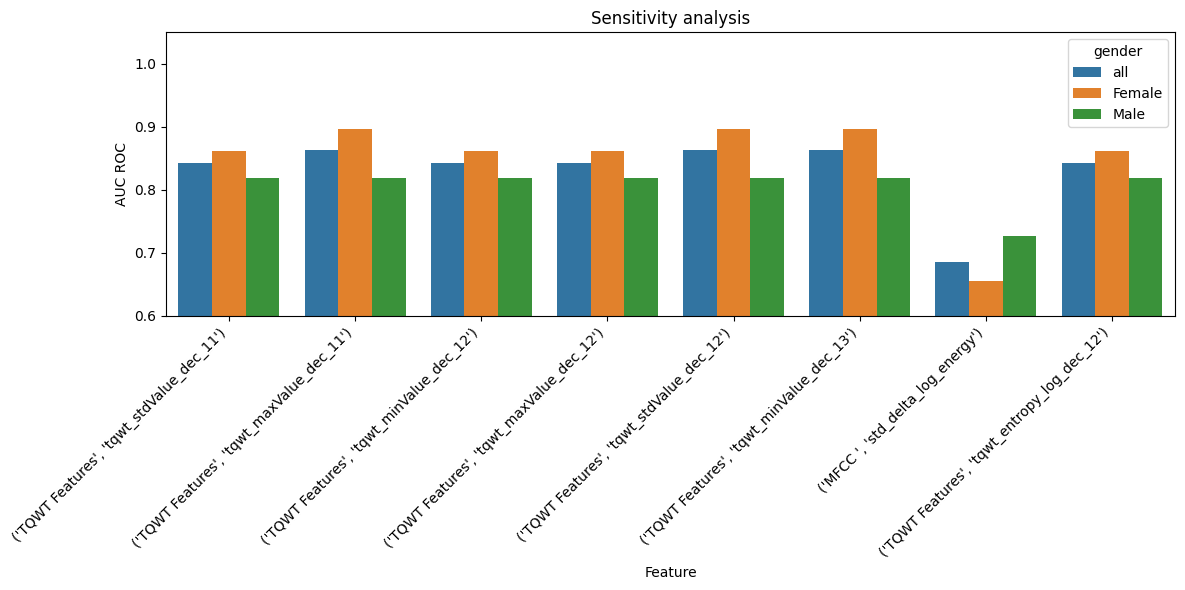

In [12]:
X_test_small = X_test[feature_list].copy()
# Gender-specific performance
for gender_label in [0, 1]:
    if gender_label == 0:
        gender = 'Female'
    else:
        gender = 'Male'
    gender_mask = (gender_test == gender_label)
    y_gender = y_test[gender_mask]
    X_gender = X_test_small[gender_mask]
    y_pred_gender = rf_small.predict(X_gender)
    print(f"{gender} accuracy: {accuracy_score(y_gender, y_pred_gender):.3f}")

# Feature importance
importances = rf_small.feature_importances_
feature_importance = pd.DataFrame({'feature': feature_list, 'importance': importances})
feature_importance = feature_importance.sort_values('importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.bar(feature_importance['feature'].astype(str), feature_importance['importance'])
plt.xticks(rotation=90)
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

gender_df = pd.DataFrame(columns=['feature removed', 'auc_roc','gender'])

# Sensitivity analysis
for feature in feature_list:
    X_test_mod = X_test_small.copy()
    X_test_mod.iloc[:, feature_list.index(feature)] = 0  # Set feature to 0
    y_pred_mod = rf_small.predict(X_test_mod)
    auc_roc = accuracy_score(y_test, y_pred_mod)
    new_row = {'feature removed': feature, 'auc_roc': auc_roc,'gender':'all'}
    gender_df = pd.concat([gender_df, pd.DataFrame([new_row])], ignore_index=True)


# ROC curves for each gender
plt.figure(figsize=(10, 6))
for gender_label in [0, 1]:
    
    gender_mask = (gender_test == gender_label)
    if gender_label == 0:
        gender = 'Female'
    else:
        gender = 'Male'
    y_gender = y_test[gender_mask]
    X_gender = X_test_small[gender_mask]
    y_pred_proba = rf_small.predict_proba(X_gender)[:, 1]
    fpr, tpr, _ = roc_curve(y_gender, y_pred_proba)
    auc_roc = roc_auc_score(y_gender, y_pred_proba)
    plt.subplot(121)
    plt.plot(fpr, tpr, label=f'{gender} (AUC = {auc_roc:.2f})')

    # Calculate Precision-Recall curve
    precision, recall, _ = precision_recall_curve(y_gender, y_pred_proba)
    auc_prc = auc(recall, precision)

    # Plot Precision-Recall curve
    plt.subplot(122)
    plt.plot(recall, precision, lw=2, label=f'{gender} (AUC = {auc_prc:.2f})')
    # Sensitivity analysis
    for feature in feature_list:
        X_test_mod = X_gender.copy()
        X_test_mod.iloc[:, feature_list.index(feature)] = 0  # Set feature to 0
        y_pred_mod = rf_small.predict(X_test_mod)
        auc_roc = accuracy_score(y_gender, y_pred_mod)
        new_row = {'feature removed': feature, 'auc_roc': auc_roc,'gender':gender}
        gender_df = pd.concat([gender_df, pd.DataFrame([new_row])], ignore_index=True)




plt.subplot(121)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve by Gender')
plt.legend()

plt.subplot(122)
plt.plot([0, 1], [1, 0], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="upper right")

plt.show()

display(gender_df)
# Convert 'feature removed' to string if it contains lists or tuples
gender_df['feature removed'] = gender_df['feature removed'].apply(lambda x: str(x) if isinstance(x, (list, tuple)) else x)

plt.figure(figsize=(12, 6))  # Adjust the figure size as needed
sns.barplot(x='feature removed', y='auc_roc', hue='gender', data=gender_df)




# Calculate the lower y-limit
lower_limit = math.floor(gender_df['auc_roc'].min() * 10) / 10

# Customize the plot
plt.title('Sensitivity analysis')
plt.xlabel('Feature')
plt.ylabel('AUC ROC')
plt.ylim([lower_limit, 1.05])

# Rotate x-axis labels if they are long
plt.xticks(rotation=45, ha='right')

# Adjust layout to prevent cutting off labels
plt.tight_layout()

# Show the plot
plt.show()